# Chunking

Geospatial data can vary in its information density from one part of the world to another. A dataset containing streets will be very dense in cities but contains little information in remote places like the Alps or even the ocean. The same is also true for datasets about the ocean or the atmosphere.

By default the number of bits that need to be kept (`keepbits`) to preserve the requested amount of information is determined based on the entire dataset. This approach doesn't always result in the best compression rates as it preserves too many keepbits in regions with anomalously low information density. The following steps show how the `keepbits` can be retrieved and applied on subsets. In this case, subsets are defined as dataset chunks.

This work is a result of the ECMWF Code4Earth 2023. Please have a look at the [presentation of this project](https://youtu.be/IOi4XvECpsQ?si=hwZkppNRa-J2XVZ9) for additional details.

## Imports

In [1]:
from itertools import product
import numpy as np

import xarray as xr
import xbitinfo as xb

## Data loading

In [2]:
# load data
ds = xr.tutorial.load_dataset("air_temperature")

# Defining chunks that will be used for the reading/bitrounding/writing
chunks = {
    "lat": 5,
    "lon": 10,
}

# Apply chunking
ds = ds.chunk(chunks)

In [3]:
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 dask.array<chunksize=(2920, 5, 10), meta=np.ndarray>
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

## Zarr chunking and compressing

In [8]:
def bitrounding(chunk, var="lat"):
    """
    Just a function that handles all the xbitinfo calls
    """
    bitinfo = xb.get_bitinformation(chunk, dim=var, implementation="python")
    keepbits = xb.get_keepbits(bitinfo, 0.99)
    bitround = xb.xr_bitround(chunk, keepbits)
    return bitround, keepbits


def slices_from_chunks(chunks):
    """Translate chunks tuple to a set of slices in product order

    >>> slices_from_chunks(((2, 2), (3, 3, 3)))  # doctest: +NORMALIZE_WHITESPACE
     [(slice(0, 2, None), slice(0, 3, None)),
      (slice(0, 2, None), slice(3, 6, None)),
      (slice(0, 2, None), slice(6, 9, None)),
      (slice(2, 4, None), slice(0, 3, None)),
      (slice(2, 4, None), slice(3, 6, None)),
      (slice(2, 4, None), slice(6, 9, None))]
    """
    cumdims = []
    for bds in chunks:
        out = np.empty(len(bds) + 1, dtype=int)
        out[0] = 0
        np.cumsum(bds, out=out[1:])
        cumdims.append(out)
    slices = [
        [slice(s, s + dim) for s, dim in zip(starts, shapes)]
        for starts, shapes in zip(cumdims, chunks)
    ]
    return list(product(*slices))

### Save dataset as compressed zarr after compressing individual chunks

In [11]:
fn = "air_bitrounded_by_chunks.zarr"  # Output filename
ds.to_compressed_zarr(fn, compute=False, mode="w")  # Creates empty file structure

dims = ds.air.dims
len_dims = len(dims)

slices = slices_from_chunks(ds.air.chunks)

# Loop over each chunk
keepbits = []
for b, block in enumerate(ds.air.data.to_delayed().ravel()):
    # Conversion of dask.delayed array to Dataset (as xbitinfo wants type xr.Dataset)
    ds_block = xr.Dataset({"air": (dims, block.compute())})

    # Apply bitrounding
    rounded_ds, keepbit = bitrounding(ds_block)
    keepbits.append(keepbit)

    # Write individual chunk to disk
    rounded_ds.to_zarr(fn, region={dims[d]: s for (d, s) in enumerate(slices[b])})

### Plot

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe

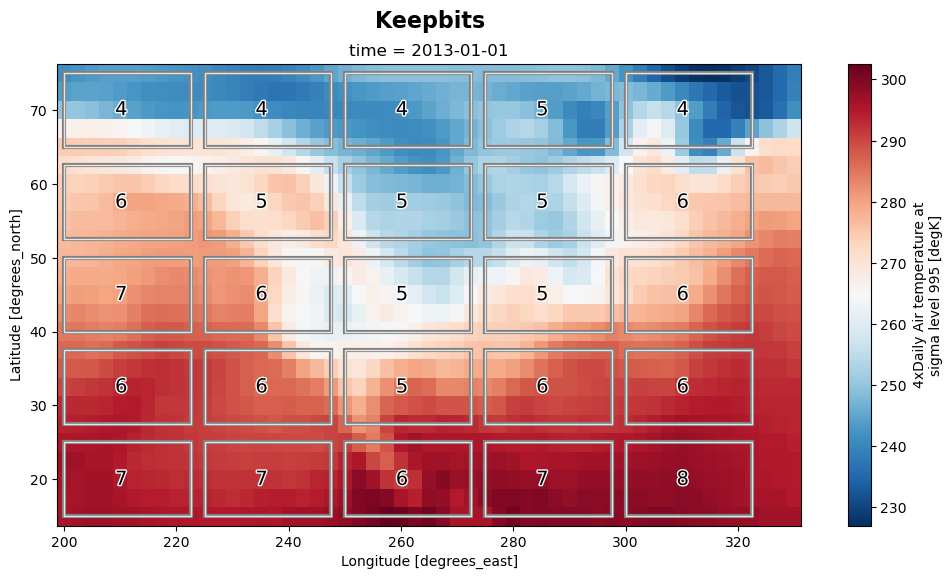

In [15]:
# # Create a figure and axis and plot the air temperature
fig, ax = plt.subplots(figsize=(12, 6))
rounded_ds = xr.open_zarr(fn).isel(time=0)
rounded_ds["air"].plot(ax=ax, cmap="RdBu_r")

slices = slices_from_chunks(rounded_ds.air.chunks)

for i in range(len(slices)):
    # Get chunk limits
    dss = rounded_ds.isel(lat=slices[i][0], lon=slices[i][1])
    lats = dss.lat
    longs = dss.lon

    x = float(min(longs[0], longs[-1]))
    y = float(min(lats[0], lats[-1]))
    w = float(abs(longs[0] - longs[-1]))
    h = float(abs(lats[0] - lats[-1]))

    # Draw rectangle
    rect = mpl.patches.Rectangle(
        (x, y),
        width=w,
        height=h,
        facecolor="none",
        edgecolor="#E5E4E2",
        path_effects=[pe.withStroke(linewidth=3, foreground="gray")],
    )
    ax.add_patch(rect)

    # Annotate number of keepbits
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width() / 2.0
    cy = ry + rect.get_height() / 2.0
    ax.annotate(
        f"{int(keepbits[i].air):2}",
        (cx, cy),
        color="k",
        weight="normal",
        fontsize=14,
        ha="right",
        va="center",
        path_effects=[pe.withStroke(linewidth=2, foreground="w")],
    )

fig.text(0.39, 0.94, f"Keepbits ", weight="bold", fontsize=16)

plt.show()

## Reference compression
For comparision with other compression approaches the dataset is also saved as:
- uncompressed netCDF
- lossless compressed zarr
- lossy compressed zarr while preserving 99% of bitinformation

### Saving to uncompressed `NetCDF` file

In [ ]:
# Saving the dataset as NetCDF file
ds.to_netcdf("0.air_original.nc")

/tmp/ipykernel_24883/1840452313.py:2: SerializationWarning: saving variable air with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds.to_netcdf("0.air_original.nc")


### Save dataset as compressed zarr (without bitrounding)

In [9]:
fn = "air_compressed.zarr"  # Output filename
ds.to_compressed_zarr(fn, mode="w")  # Creates empty file structure

### Save dataset as compressed zarr after applying bitrounding

In [ ]:
fn = "air_bitrounded.zarr"  # Output filename
rounded_ds, keepbits = bitrounding(ds)
rounded_ds.to_compressed_zarr(fn, mode="w")

## Summary

Below are the file sizes resulting from the various compression techniques outlined above.

In [16]:
!du -hs *.nc *.zarr

7.5M	0.air_original.nc
1.7M	1.air_compressed_all.nc
1.3M	2.air_bitrounded_compressed.nc
776K	3.air_chunked_bitr_compressed.nc
1.1M	air.zarr


---

In this experiment, the sizes are minimized when applying bitrounding and compression to the dataset chunks. 

However, it's important to note that this outcome may not be universally applicable, check this for your dataset.